# Ethereum Price Prediction

In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

In [3]:
from cryptocmd import CmcScraper

scraper = CmcScraper("ETH")
headers, data = scraper.get_data()
json_data = scraper.get_data("json")

# dataset with open, high, low, close, volume, market cap
ohlc = scraper.get_dataframe()
ohlc.sort_values(by='Date', inplace=True)

# Exploratory Data Analysis and Feature Selection

## Check for missing data

In [4]:
ohlc.isna().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

In [5]:
ohlc

,Date,Open,High,Low,Close,Volume,Market Cap
2907,2015-08-07,2.832,3.537,2.521,2.772,164329.000,166610555.018
2906,2015-08-08,2.794,2.799,0.715,0.753,674188.000,45486894.241
2905,2015-08-09,0.706,0.880,0.629,0.702,532170.000,42399573.499
2904,2015-08-10,0.714,0.730,0.637,0.708,405283.000,42818364.395
2903,2015-08-11,0.708,1.131,0.663,1.068,1463100.000,64569288.433
...,...,...,...,...,...,...,...
4,2023-07-19,1897.797,1919.264,1883.067,1889.008,6018487800.400,227057271106.860
3,2023-07-20,1889.074,1919.264,1879.734,1890.969,7366830683.510,227287014709.890
2,2023-07-21,1891.581,1905.386,1885.296,1892.080,4668158259.720,227568017429.560
1,2023-07-22,1891.955,1897.088,1855.093,1864.912,4101305643.350,224150871476.760


In [6]:
ohlc.shape

(2908, 7)

The dataset consists of Ethereum's historical daily open, high, low, close prices, as well as volume and market capitalization (2015-08-07 - present)

## Time Dependent Variables

In [7]:
ohlc['dayofweek'] = ohlc['Date'].apply(lambda x: x.isoweekday())
ohlc['month'] = ohlc['Date'].apply(lambda x: x.month)
ohlc['year'] = ohlc['Date'].apply(lambda x: x.year)

## Relative Strength Index (RSI)

In [8]:
def rsi(df, n=14):
    """
    Compute relative strength indicator (RSI) which provides signals about upward or downward price momentum.
    An asset is considered overbought when the RSI > 70 and oversold when RSI < 30.
    """
    close = df['Close']
    diff = close.diff().dropna()
    diff_up = diff.copy()
    diff_down = diff.copy()
    diff_up[diff_up < 0] = 0
    diff_down[diff_down > 0] = 0
    
    # rolling average up and average down
    avg_up = diff_up.rolling(n).mean()
    avg_down = diff_down.abs().rolling(n).mean()
    
    ratio = avg_up / avg_down
    idx = 100.0 - (100.0 / (1.0 + ratio))
    return idx

In [9]:
df = ohlc.copy()
df['RSI'] = rsi(df).fillna(50)

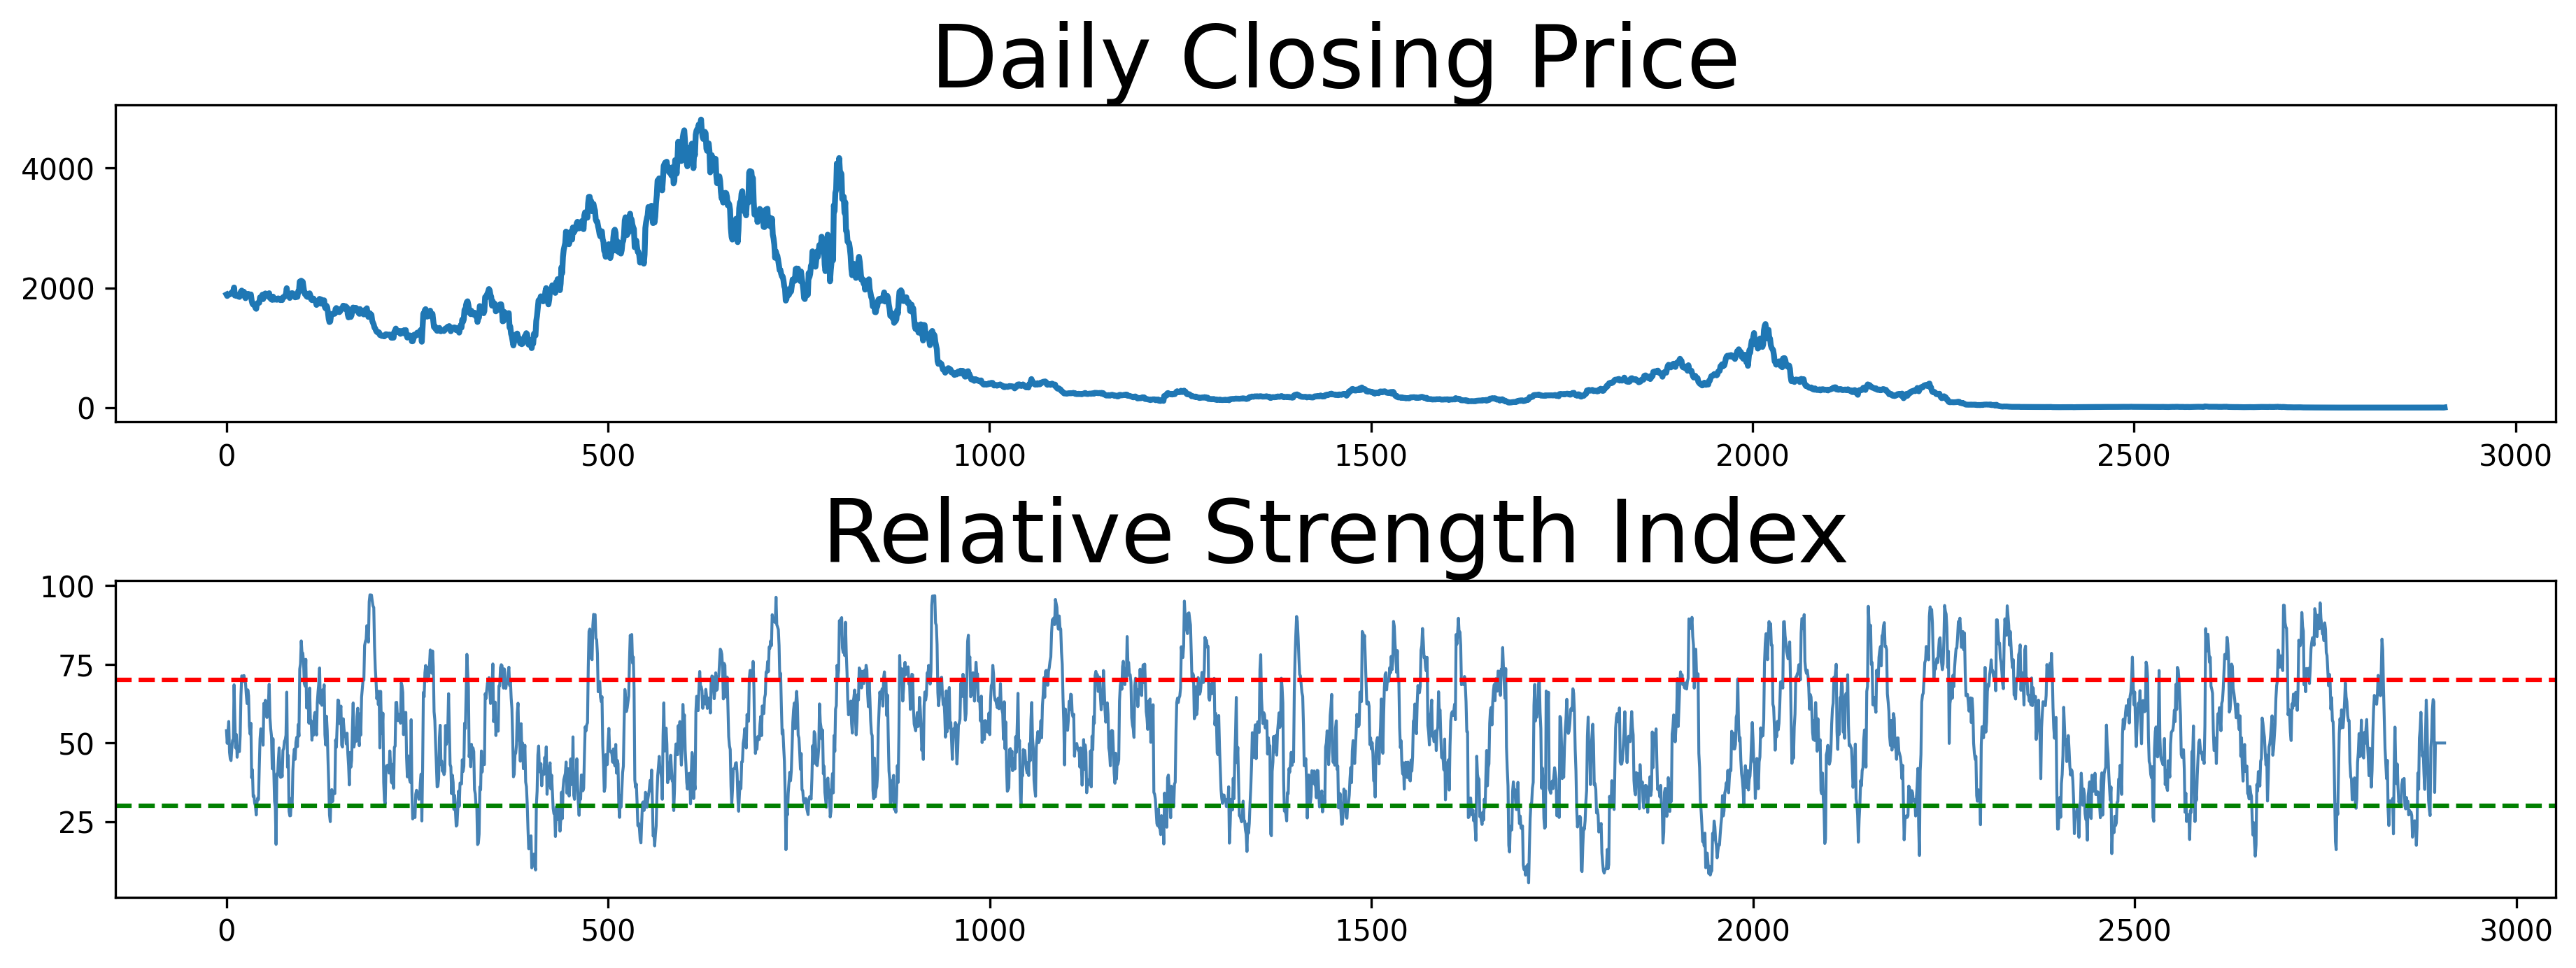

In [10]:
fig = plt.figure(figsize=(15,5), dpi=300)
gs = fig.add_gridspec(2, hspace=0.5)
ax = gs.subplots(sharex=False, sharey=False)
ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

# closing price
ax[0].plot(df['Close'], linewidth=2)
ax[0].set_title('Daily Closing Price', fontsize=30)

# RSI
ax[1].set_title('Relative Strength Index', fontsize=30)
ax[1].plot(df['RSI'], color='steelblue', linewidth=1)

# Oversold
ax[1].axhline(30, linestyle='--', linewidth=1.5, color='green')
# Overbought
ax[1].axhline(70, linestyle='--', linewidth=1.5, color='red')

In [11]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
df['price_lag_1'] = df['Close'].shift(1)
df['price_lag_7'] = df['Close'].shift(7)
df['price_lag_14'] = df['Close'].shift(14)
df['SMA3'] = df['Close'].rolling(3).mean()

# target variable (next day's price)
df['next_price'] = df['Close'].shift(-1)

df.index = df['Date']
df.dropna(inplace=True)
df.drop(columns=['Open','High','Low','Date'], inplace=True)

In [12]:
df.dtypes

Close           float64
Volume          float64
Market Cap      float64
dayofweek         int64
month             int64
year              int64
RSI             float64
MACD            float64
MACD_signal     float64
price_lag_1     float64
price_lag_7     float64
price_lag_14    float64
SMA3            float64
next_price      float64
dtype: object

In [13]:
df

,Close,Volume,Market Cap,dayofweek,month,year,RSI,MACD,MACD_signal,price_lag_1,price_lag_7,price_lag_14,SMA3,next_price
Date,,,,,,,,,,,,,,
2015-09-09,1.207,366748.000,88150124.711,3,9,2015,54.309,-0.015,-0.011,1.242,1.295,1.160,1.232,1.166
2015-09-10,1.166,662782.000,85202731.663,4,9,2015,51.589,-0.022,-0.013,1.207,1.265,1.148,1.205,0.983
2015-09-11,0.983,1942600.000,71868264.580,5,9,2015,35.273,-0.040,-0.019,1.166,1.274,1.191,1.118,1.039
2015-09-12,1.039,772430.000,75971273.152,6,9,2015,40.470,-0.050,-0.026,0.983,1.339,1.183,1.062,0.936
2015-09-13,0.936,644138.000,68480586.716,7,9,2015,23.402,-0.065,-0.034,1.039,1.296,1.319,0.986,0.876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-18,1897.599,5814708444.980,228092963187.170,2,7,2023,44.955,18.364,20.208,1911.646,1878.336,1936.634,1910.976,1889.008
2023-07-19,1889.008,6018487800.400,227057271106.860,3,7,2023,47.079,15.384,19.243,1897.599,1872.114,1910.588,1899.418,1890.969
2023-07-20,1890.969,7366830683.510,227287014709.890,4,7,2023,56.841,13.030,18.000,1889.008,2006.512,1848.636,1892.525,1892.080


In [14]:
# save dataset to a csv file
# df.to_csv('BTC.csv')

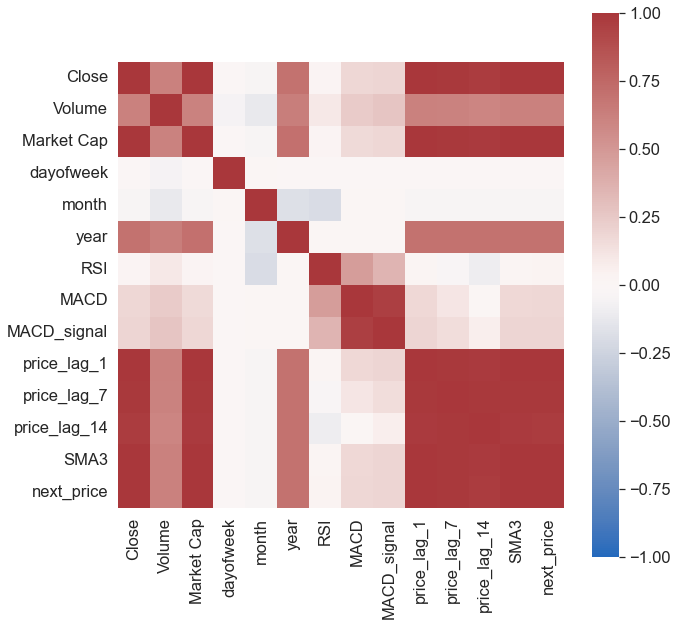

In [15]:
corr = df.corr()

plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
sns.heatmap(corr, vmin=-1, vmax=1, cbar=1, square=1, cmap='vlag')
plt.savefig('heatmap1.png', facecolor=None)

# Price Prediction Using XGBoost

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost
from xgboost import XGBRegressor
sns.set(font_scale=1.2)

In [17]:
# parameters = {
#     'n_estimators': [200, 300, 400],
#     'learning_rate': [0.001, 0.005, 0.01, 0.05],
#     'max_depth': [4, 6, 8],
#     'gamma': [0.001, 0.005, 0.01, 0.02],
#     'random_state': [2]
# }

# eval_set = [(X_train, y_train), (X_val, y_val)]
# model = XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
# clf = GridSearchCV(model, parameters)

# clf.fit(X_train, y_train)

In [18]:
X = df.drop(columns=['next_price'])
y = df['next_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

In [19]:
model = XGBRegressor(booster='gbtree', objective='reg:squarederror', learning_rate=0.1,
                    n_estimators=200, random_state=2, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

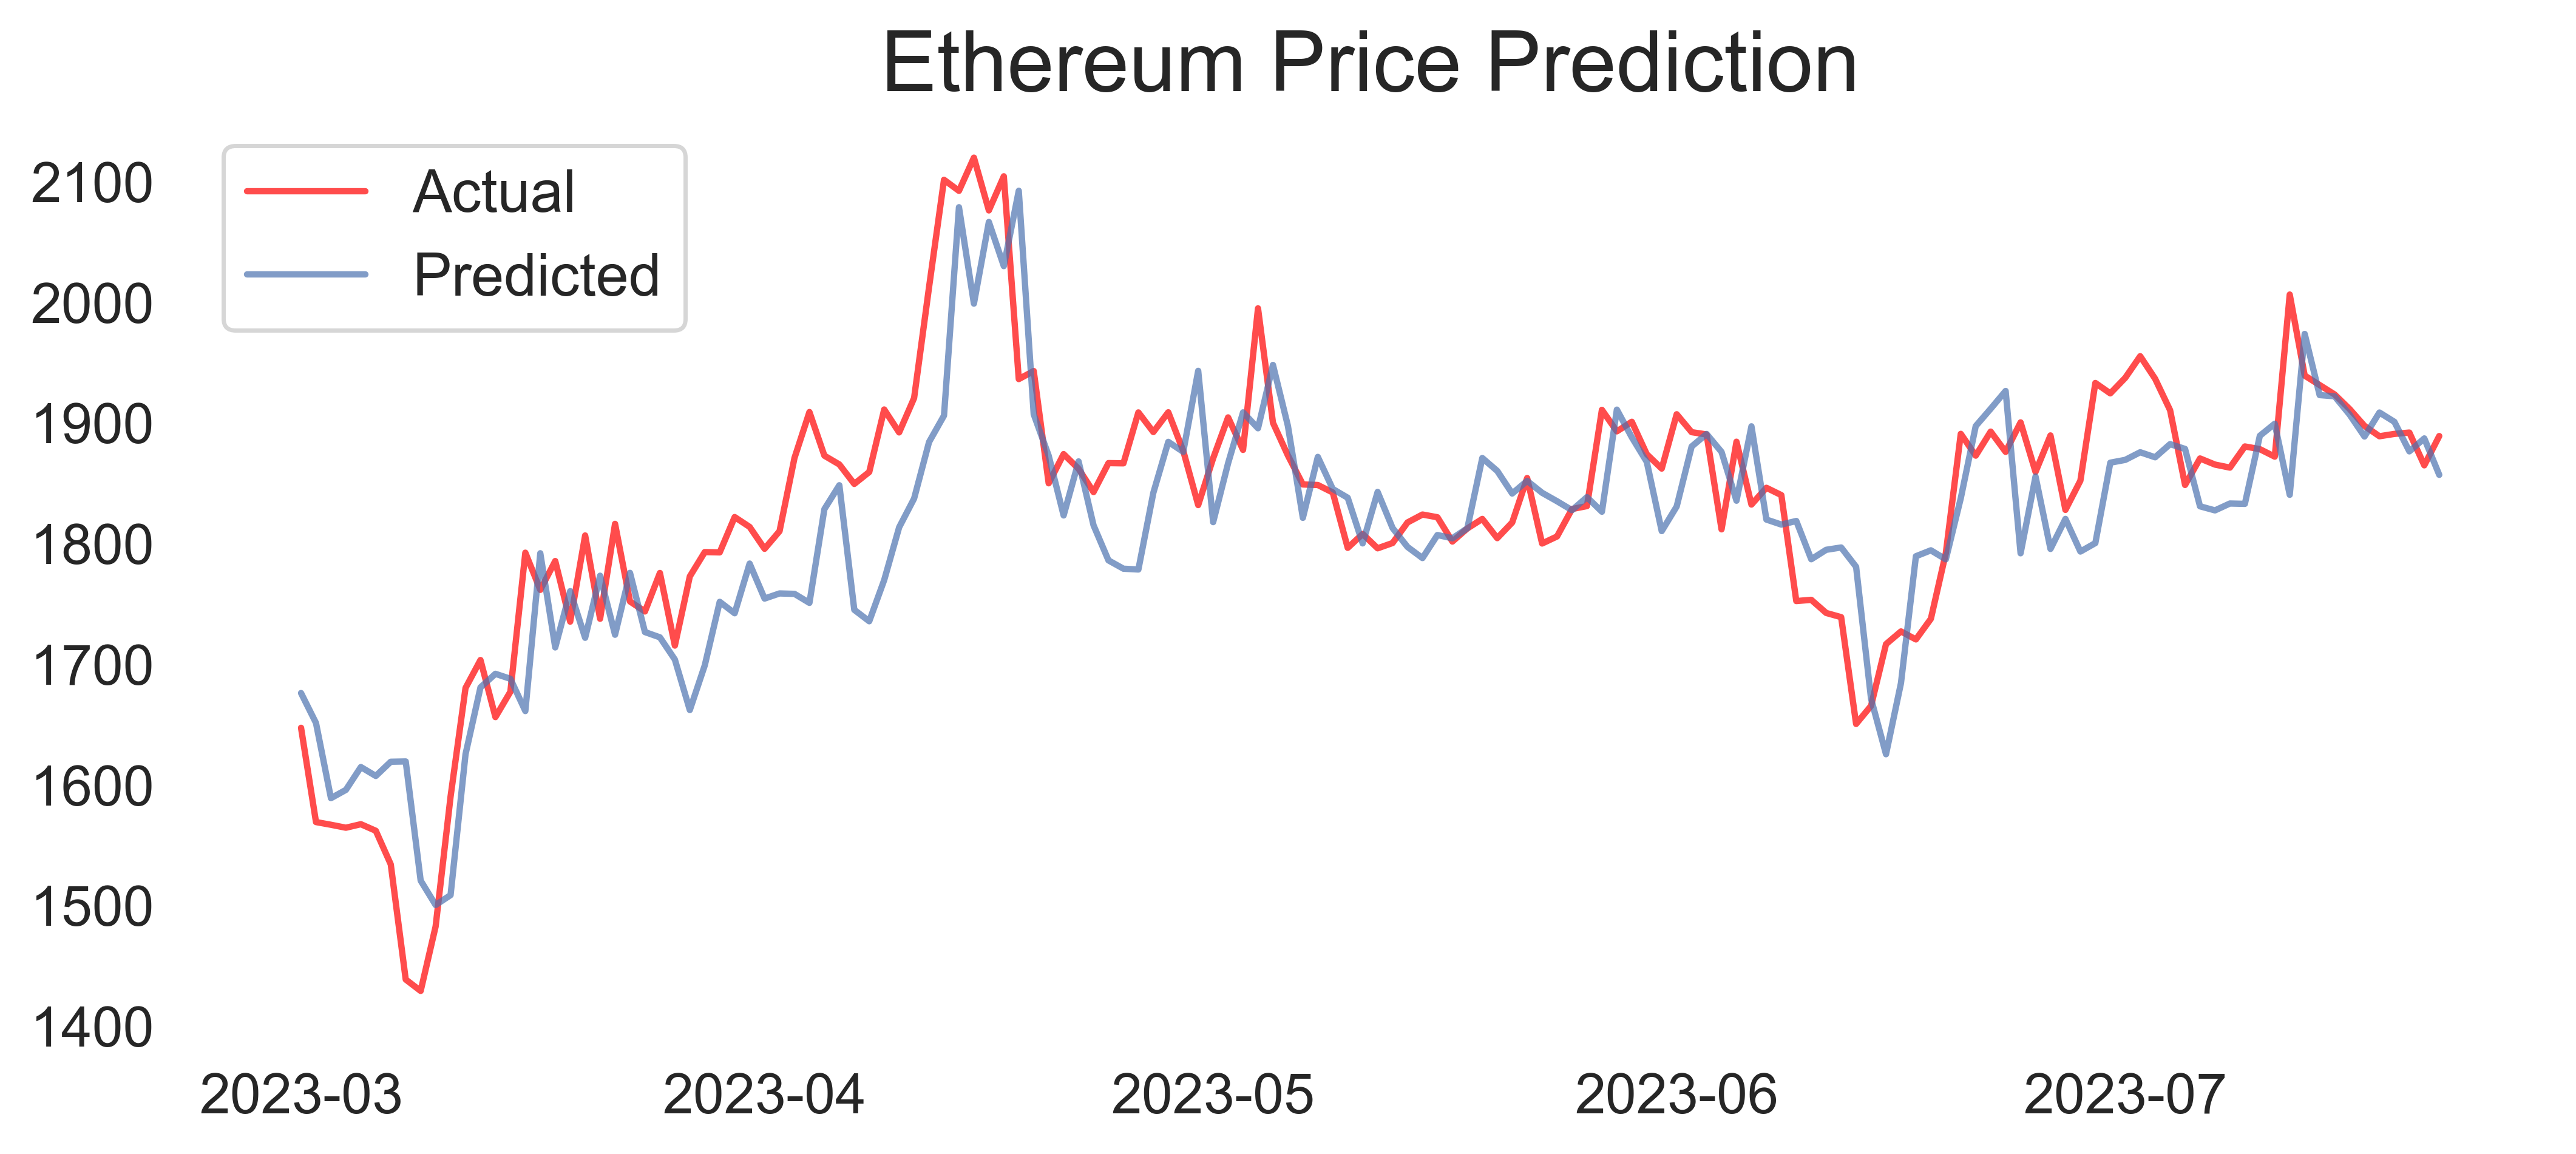

In [20]:
plt.figure(figsize=(10,4), dpi=500)
ax = plt.axes()
ax.set(facecolor = 'white')
plt.plot(y_test.index, y_test, label='Actual', c='red', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.legend(facecolor='white', fontsize=14)
plt.title('Ethereum Price Prediction', fontsize=20)
plt.show()

## Feature Importance

The scores show how many times each feature was split on.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

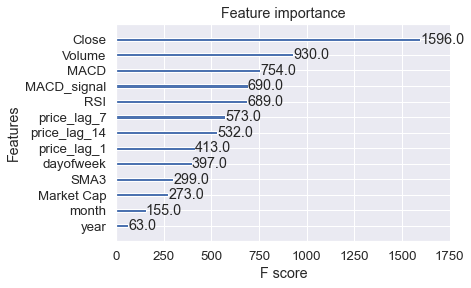

In [21]:
xgboost.plot_importance(model)

## Error Metrics

In [22]:
from sklearn.metrics import mean_absolute_percentage_error as mape
print("Mean Absolute Percentage Error:" + str(mape(y_test, y_pred)))

Mean Absolute Percentage Error:0.02779917839328684


In [23]:
import math
from sklearn.metrics import mean_squared_error as mse
print("Root Mean Squared Error:" + str(math.sqrt(mse(y_test, y_pred))))

Root Mean Squared Error:65.58217433472282


## Train Loss vs Test Loss

In [24]:
evalset = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric='rmse', eval_set=evalset)
yhat = model.predict(X_test)
results = model.evals_result()

[0]	validation_0-rmse:1244.87828	validation_1-rmse:1650.21550
[1]	validation_0-rmse:1122.36567	validation_1-rmse:1485.17629
[2]	validation_0-rmse:1012.06773	validation_1-rmse:1347.37004
[3]	validation_0-rmse:912.64627	validation_1-rmse:1212.23258
[4]	validation_0-rmse:823.17828	validation_1-rmse:1091.24877
[5]	validation_0-rmse:742.50523	validation_1-rmse:981.35884
[6]	validation_0-rmse:669.83090	validation_1-rmse:885.44137
[7]	validation_0-rmse:604.41644	validation_1-rmse:798.08140
[8]	validation_0-rmse:545.49219	validation_1-rmse:720.36153
[9]	validation_0-rmse:492.37839	validation_1-rmse:648.06176
[10]	validation_0-rmse:444.60755	validation_1-rmse:585.46100


C:\Users\S\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-rmse:401.62559	validation_1-rmse:526.23601
[12]	validation_0-rmse:362.95181	validation_1-rmse:473.90847
[13]	validation_0-rmse:328.18050	validation_1-rmse:427.28954
[14]	validation_0-rmse:296.87808	validation_1-rmse:387.26407
[15]	validation_0-rmse:268.78828	validation_1-rmse:350.37390
[16]	validation_0-rmse:243.50517	validation_1-rmse:317.31078
[17]	validation_0-rmse:220.80967	validation_1-rmse:289.46949
[18]	validation_0-rmse:200.45619	validation_1-rmse:262.35748
[19]	validation_0-rmse:182.21088	validation_1-rmse:238.10306
[20]	validation_0-rmse:165.82866	validation_1-rmse:215.88173
[21]	validation_0-rmse:151.18162	validation_1-rmse:196.90620
[22]	validation_0-rmse:138.10077	validation_1-rmse:182.25748
[23]	validation_0-rmse:126.34541	validation_1-rmse:168.77251
[24]	validation_0-rmse:115.87306	validation_1-rmse:154.92035
[25]	validation_0-rmse:106.53802	validation_1-rmse:143.72253
[26]	validation_0-rmse:98.18836	validation_1-rmse:131.31976
[27]	validation_0-rmse:90

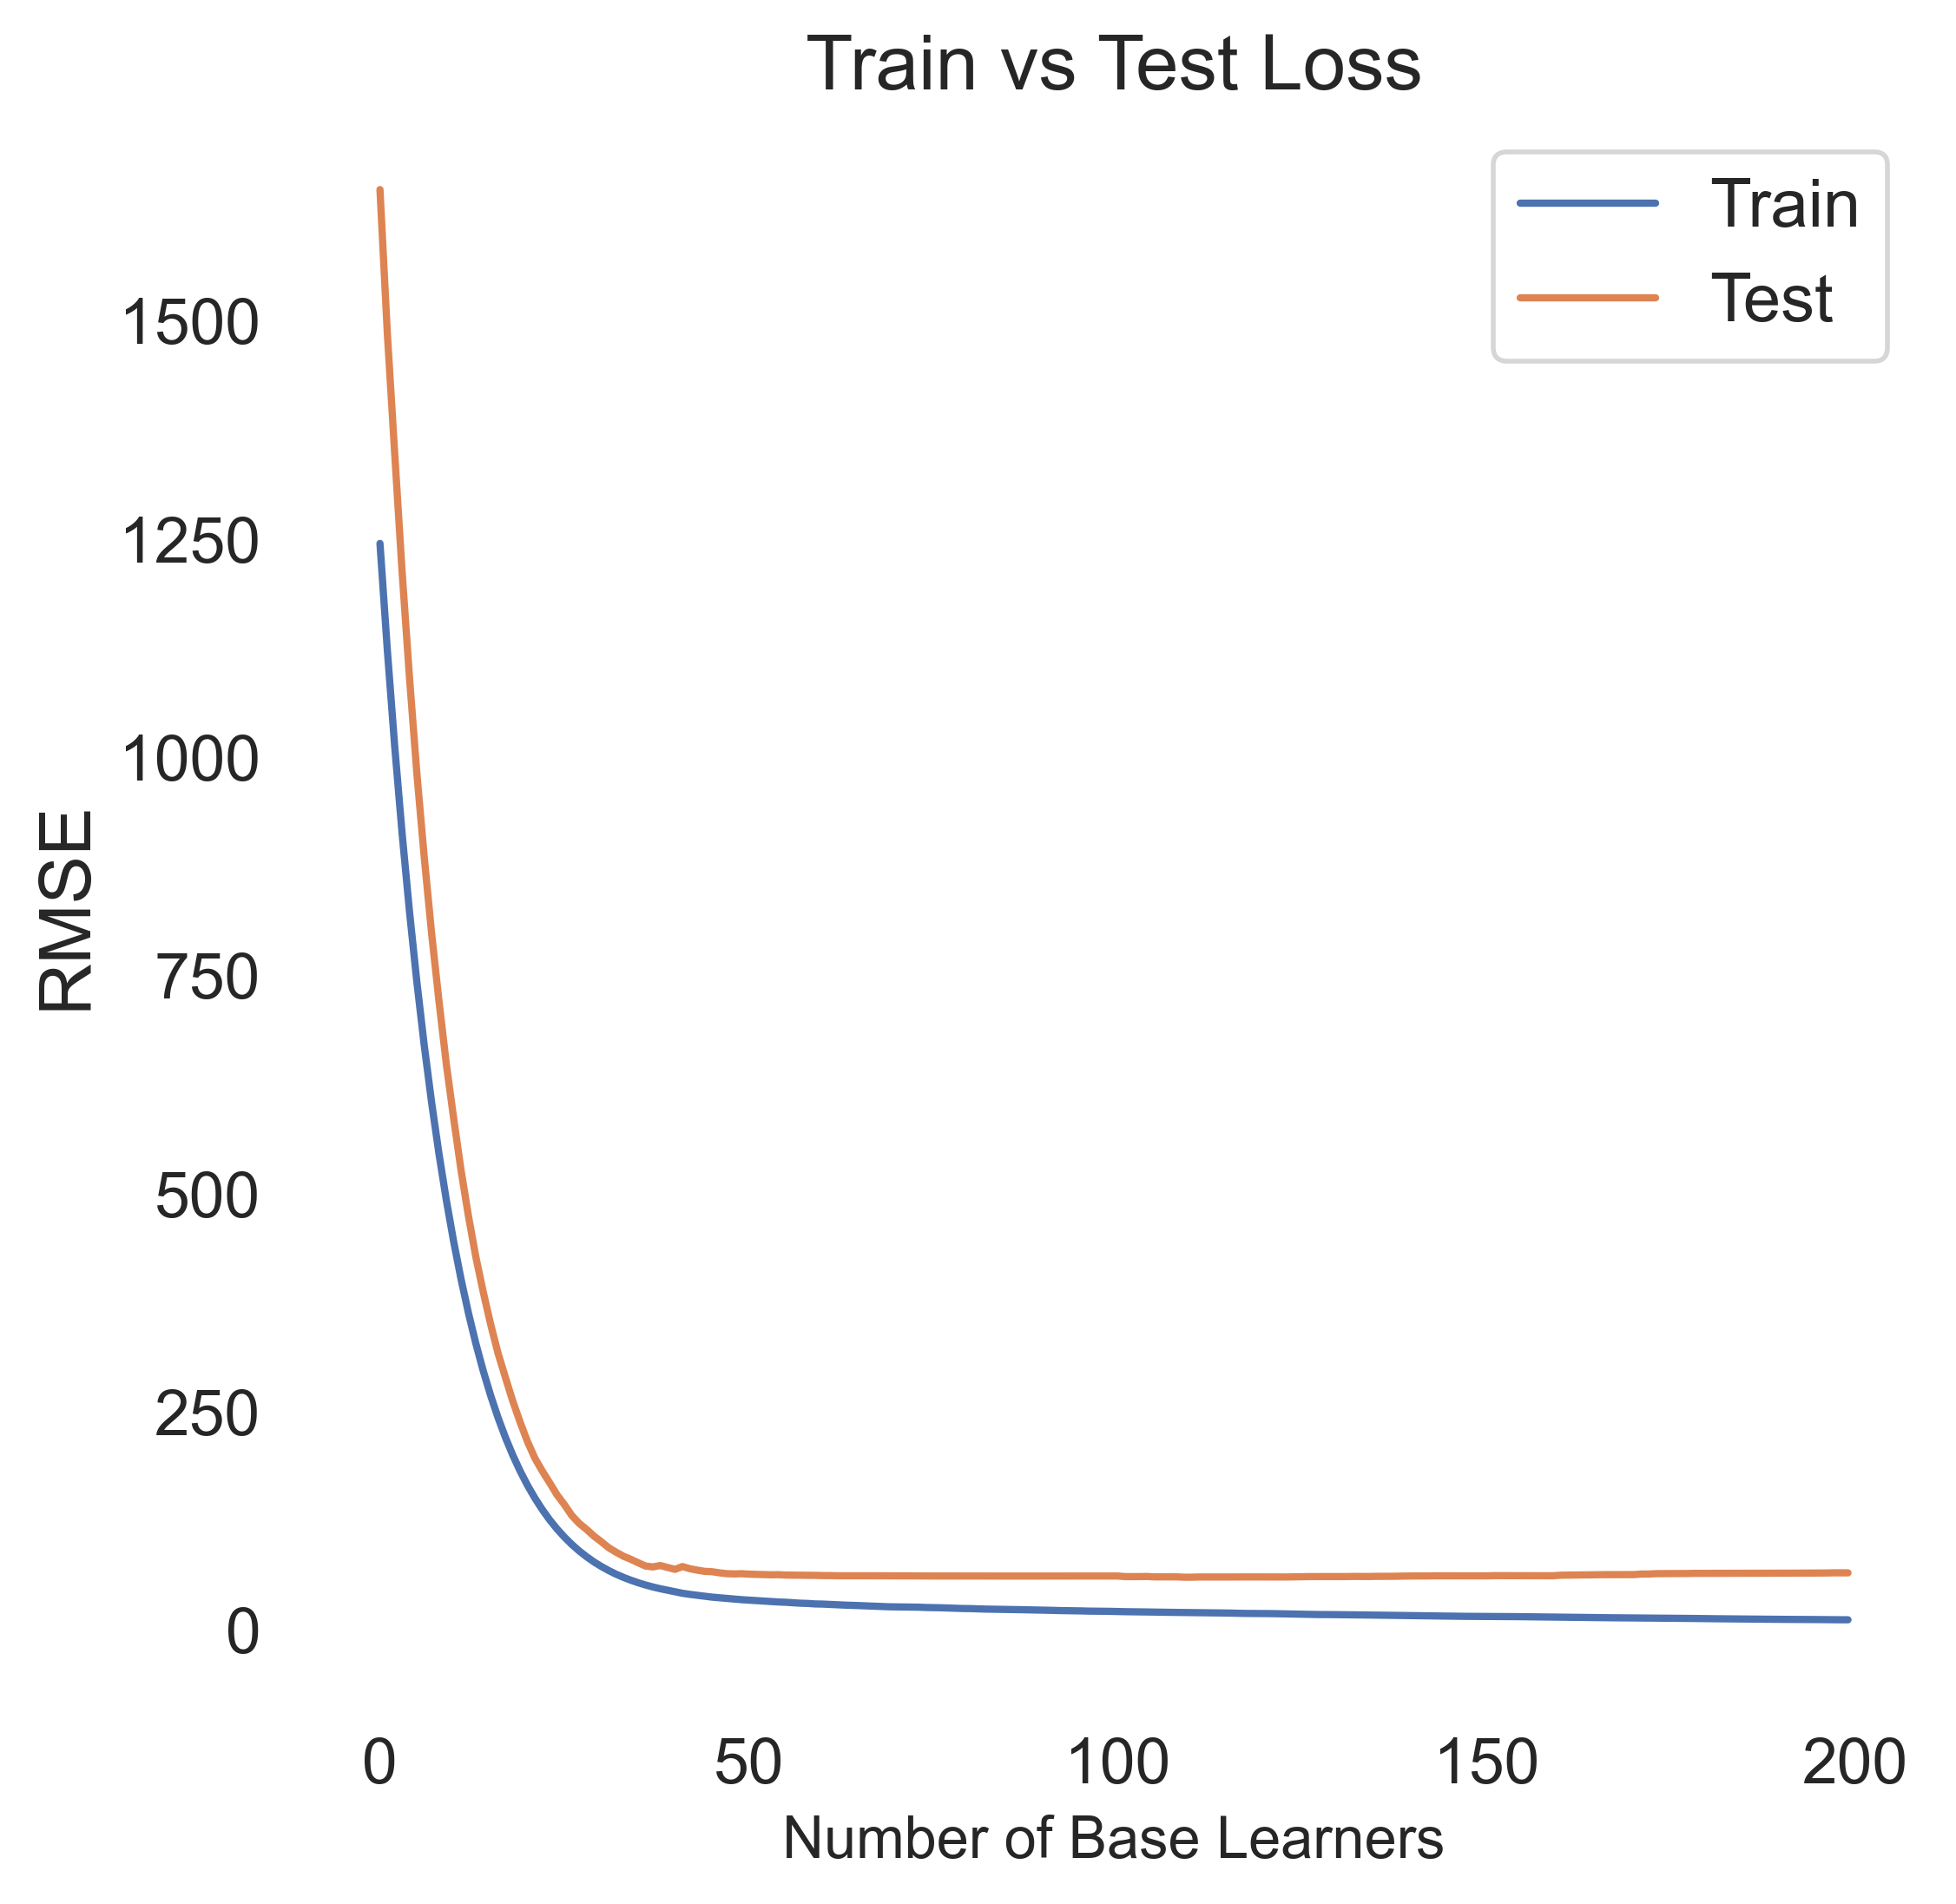

In [25]:
# plot
plt.figure(figsize=(6,6),dpi=400)
ax = plt.axes()
ax.set(facecolor = 'white')

plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.title('Train vs Test Loss', fontsize=16)
plt.xlabel('Number of Base Learners', fontsize=12)
plt.ylabel('RMSE', fontsize=15)
plt.legend(facecolor='white', fontsize=14)
plt.show()

## Prediction on whether the price will go up or down the following day (binary classification)

In [26]:
pred_all = model.predict(X)
df['predicted_next_price'] = pred_all
df['price_goes_up'] = ''
# 1 if price goes up the following day; 0 otherwise
df.loc[df['Close'] < df['next_price'], 'price_goes_up'] = 1
df.loc[df['Close'] >= df['next_price'], 'price_goes_up'] = 0
df['price_goes_up'] = df['price_goes_up'].astype(int)

df['predicted_up'] = ''
# 1 if the price is predicted to go up the following day; 0 otherwise
df.loc[df['Close'] < df['predicted_next_price'], 'predicted_up'] = 1
df.loc[df['Close'] >= df['predicted_next_price'], 'predicted_up'] = 0
df['predicted_up'] = df['predicted_up'].astype(int)

In [27]:
df.dtypes

Close                   float64
Volume                  float64
Market Cap              float64
dayofweek                 int64
month                     int64
year                      int64
RSI                     float64
MACD                    float64
MACD_signal             float64
price_lag_1             float64
price_lag_7             float64
price_lag_14            float64
SMA3                    float64
next_price              float64
predicted_next_price    float32
price_goes_up             int32
predicted_up              int32
dtype: object

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
accuracy_score(list(df['price_goes_up']), list(df['predicted_up']))

0.7581767571329158

The price prediction model has 75.8% accuracy on whether the price will go up the following day.

Can we improve the prediction accuracy if we train the model with 'predicted_up' as the target variable? (binary classification problem)

## Prediction on whether the price will go up the following day

In [30]:
X = df.drop(columns=['predicted_up','predicted_next_price','next_price'])
y = df['predicted_up']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

In [31]:
clf = xgboost.XGBClassifier(enable_categorical=True, tree_method='hist', booster='gbtree', objective='binary:logistic', learning_rate=0.1,
                    n_estimators=100, random_state=2, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_up = clf.predict(X_test)

In [32]:
y_pred_up

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1])

In [33]:
accuracy_score(y_test, y_pred_up)

0.5277777777777778

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

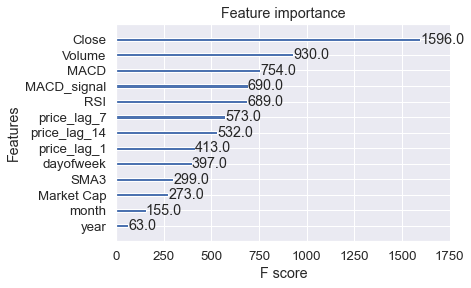

In [34]:
xgboost.plot_importance(model)

The results show that it's actually much less accurate to predict the binary variable 'predicted_up' (whether the price wil go up the following day) directly.